In [1]:
%load_ext autoreload
%autoreload 2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import argparse
import repackage

import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [2]:
from experiment_utils import set_env, seed_everything
set_env()
from cgn_extensions.mnists.dataloaders import get_dataloaders

# Train concept classifier for double-colored-MNIST
We need to train:
1. A CF for classifying the digit's color
2. A CF for classifying the digit's shape
3. A CF for background color

## Load dataset

In [3]:
dl_train, dl_test = get_dataloaders('double_colored_MNIST', batch_size=1000, workers=8)

### Dataset size

In [4]:
print(f"Train: {dl_train.dataset.labels.shape[0]}")
print(f"Test: {dl_test.dataset.labels.shape[0]}")

Train: 50000
Test: 10000


### Get a sample image

In [5]:
random_idx = np.random.randint(0, dl_train.dataset.labels.shape[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


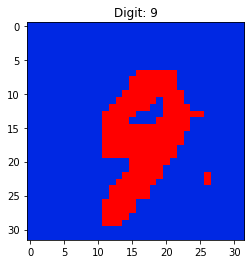

BG label: tensor([0.3854, 0.5716, 0.9293])
Texture label: tensor([ 1.0043e+00,  2.5653e-01, -5.9458e-04])


In [6]:
plt.imshow(dl_train.dataset.__getitem__(random_idx)['ims'].transpose(0,1).transpose(1,2))
label = dl_train.dataset.__getitem__(random_idx)['labels']
plt.title(f"Digit: {label}")
plt.show()
print(f"BG label: {dl_train.dataset.__getitem__(random_idx)['bg_labels']}")
print(f"Texture label: {dl_train.dataset.__getitem__(random_idx)['texture_labels']}")

## Train color CF

In [17]:
from cgn_extensions.mnists.models.mnist_color_cf import train, test, RGB_CNN

# Args for training
args = argparse.Namespace()
args.batch_size = 1000
args.gamma = 0.7
args.epochs = 10
args.lr = 0.01
args.log_interval = 10
args.dataset = 'double_colored_MNIST'

# Data
dl_train, dl_test = get_dataloaders(args.dataset, batch_size=args.batch_size, workers=8)

# Model
model = RGB_CNN()

# Optimizer
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)
scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)

# push to device and train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
device

device(type='cuda')

In [18]:
train_accs = dict()
test_accs = dict()
for epoch in range(1, args.epochs + 1):
    train_acc = train(args, model, device, dl_train, optimizer, epoch, 'texture', max_batches=100)
    test_acc = test(model, device, dl_test, 'texture')
    train_accs[epoch] = train_acc
    test_accs[epoch] = test_acc
    scheduler.step()

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.765481
Train Epoch: 1 [10000/50000 (20%)]	Loss: 0.941879
Train Epoch: 1 [20000/50000 (40%)]	Loss: 0.659872
Train Epoch: 1 [30000/50000 (60%)]	Loss: 0.509041
Train Epoch: 1 [40000/50000 (80%)]	Loss: 0.401818
Train set: Average epoch loss: 0.6975

Test set: Average loss: 0.7243

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.311198
Train Epoch: 2 [10000/50000 (20%)]	Loss: 0.265557
Train Epoch: 2 [20000/50000 (40%)]	Loss: 0.239384
Train Epoch: 2 [30000/50000 (60%)]	Loss: 0.205464
Train Epoch: 2 [40000/50000 (80%)]	Loss: 0.183064
Train set: Average epoch loss: 0.2259

Test set: Average loss: 0.6366

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.161527
Train Epoch: 3 [10000/50000 (20%)]	Loss: 0.147298
Train Epoch: 3 [20000/50000 (40%)]	Loss: 0.137951
Train Epoch: 3 [30000/50000 (60%)]	Loss: 0.124160
Train Epoch: 3 [40000/50000 (80%)]	Loss: 0.117503
Train set: Average epoch loss: 0.1338

Test set: Average loss: 0.6014

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.112317
Train E

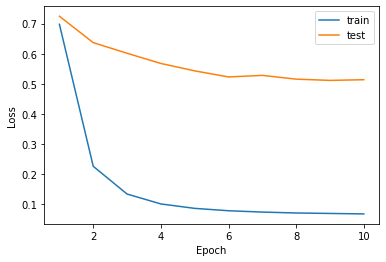

In [19]:
# Plot losses
plt.plot(train_accs.keys(), train_accs.values())
plt.plot(test_accs.keys(), test_accs.values())
plt.legend(['train', 'test'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# # save the final model
# dataset_suffix = (args.dataset) if not args.combined else (args.dataset + "_combined")
# dataset_suffix += "_seed_" + str(args.seed) if args.seed is not None else ""
# save_path = f'mnists/experiments/classifier_{dataset_suffix}/weights/ckp_epoch_{args.epochs}.pth'
# os.makedirs(os.path.dirname(save_path), exist_ok=True)
# print('Saving model to {}'.format(save_path))
# torch.save(model.state_dict(), save_path)

### Make some predictions

## Train shape CF

## Train background CF